In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 256
LR = 0.0003
UP_COEF = 0.25
GAMMA = 0.99
EPS = 1e-8

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class DQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.SELU(),
            nn.Linear(256, 256),
            nn.SELU()
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        q = self.fc(out).reshape(out.shape[0], -1)

        return q

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    global action_space
    net.train()
    tgt_net.train()

    train_data = random.sample(rep_memory, BATCH_SIZE)
    dataloader = DataLoader(
        train_data, batch_size=BATCH_SIZE, pin_memory=use_cuda)

    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.detach().to(device).float()
        done_mask = 1 - d.detach().to(device).float()

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            _q_acting_tgt = _q_batch_tgt[range(BATCH_SIZE), a_batch]

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = ((r_batch + GAMMA * done_mask * _q_acting_tgt) - q_acting).pow(2).mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = tgt_net(state)
        action = torch.argmax(q)

    return action.item()

## Main

In [5]:
# make an environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 1500
memory_size = 50000
update_frq = 1
use_eps_decay = False
epsilon = 0.001
eps_min = 0.001
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make two nerual networks
net = DQN(obs_space, action_space).to(device)
target_net = deepcopy(net)

# make optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=EPS)

# make a memory
rep_memory = deque(maxlen=memory_size)

In [6]:
use_cuda

True

In [7]:
env.spec.max_episode_steps

200

In [8]:
env.spec.trials

100

In [9]:
env.spec.reward_threshold

195.0

In [10]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward

        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            for t, n in zip(target_net.parameters(), net.parameters()):
                t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                torch.save(target_net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_dqn.pt')
                break
env.close()

  1 Episode in    10 steps, reward 10.00
  2 Episode in    18 steps, reward 8.00
  3 Episode in    28 steps, reward 10.00
  4 Episode in    38 steps, reward 10.00
  5 Episode in    48 steps, reward 10.00
  6 Episode in    58 steps, reward 10.00
  7 Episode in    67 steps, reward 9.00
  8 Episode in    78 steps, reward 11.00
  9 Episode in    88 steps, reward 10.00
 10 Episode in    98 steps, reward 10.00
 11 Episode in   107 steps, reward 9.00
 12 Episode in   115 steps, reward 8.00
 13 Episode in   124 steps, reward 9.00
 14 Episode in   133 steps, reward 9.00
 15 Episode in   143 steps, reward 10.00
 16 Episode in   153 steps, reward 10.00
 17 Episode in   163 steps, reward 10.00
 18 Episode in   172 steps, reward 9.00
 19 Episode in   181 steps, reward 9.00
 20 Episode in   190 steps, reward 9.00
 21 Episode in   198 steps, reward 8.00
 22 Episode in   207 steps, reward 9.00
 23 Episode in   215 steps, reward 8.00
 24 Episode in   226 steps, reward 11.00
 25 Episode in   236 steps, 

203 Episode in  2991 steps, reward 200.00
204 Episode in  3191 steps, reward 200.00
205 Episode in  3391 steps, reward 200.00
206 Episode in  3591 steps, reward 200.00
207 Episode in  3791 steps, reward 200.00
208 Episode in  3991 steps, reward 200.00
209 Episode in  4191 steps, reward 200.00
210 Episode in  4391 steps, reward 200.00
211 Episode in  4591 steps, reward 200.00
212 Episode in  4773 steps, reward 182.00
213 Episode in  4895 steps, reward 122.00
214 Episode in  5070 steps, reward 175.00
215 Episode in  5270 steps, reward 200.00
216 Episode in  5470 steps, reward 200.00
217 Episode in  5603 steps, reward 133.00
218 Episode in  5754 steps, reward 151.00
219 Episode in  5952 steps, reward 198.00
220 Episode in  6140 steps, reward 188.00
221 Episode in  6337 steps, reward 197.00
222 Episode in  6537 steps, reward 200.00
223 Episode in  6732 steps, reward 195.00
224 Episode in  6932 steps, reward 200.00
225 Episode in  7132 steps, reward 200.00
226 Episode in  7332 steps, reward

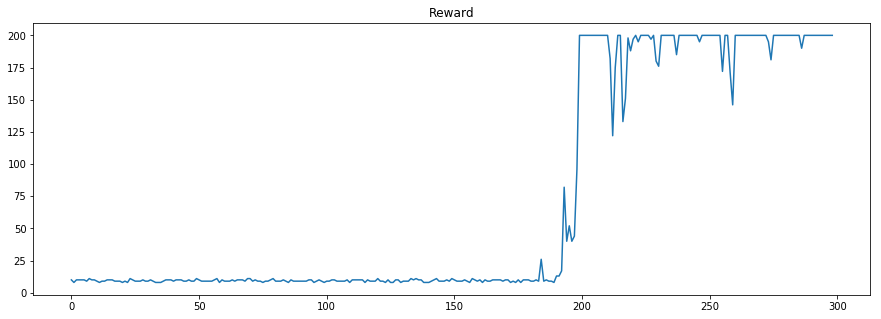

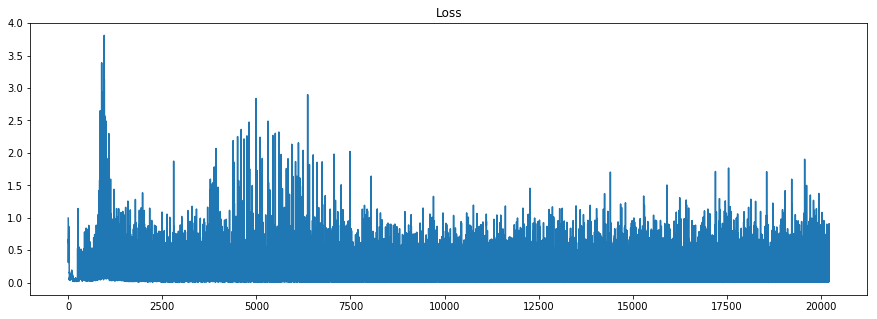

In [11]:
plt.figure(figsize=(15, 5))
plt.title('Reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(losses)
plt.show()

In [12]:
[
    ('CartPole-v0', 299, 0.25),
    ('CartPole-v1', 413, 0.025),
    ('MountainCar-v0', None ,0.05)
]

[('CartPole-v0', 299, 0.25),
 ('CartPole-v1', 413, 0.025),
 ('MountainCar-v0', None, 0.05)]